# Image channels processing and alignment
This project was completed as an assignment in https://www.coursera.org/learn/deep-learning-in-computer-vision/


Sergey Prokudin-Gorsky was the first color photographer in Russia, who made the color portrait of Leo Tolstoy. Each of his photographs is three black-and-white photo plates, corresponding to red, green, and blue color channels. Currently, the collection of his pictures is situated in the U.S. Library of Congress, the altered versions have proliferated online. 

This program takes three black and white plates and aligns them into one RGB image like the example below:

*The input image and the result of the alignment:*
<img src="http://cdn1.savepice.ru/uploads/2017/7/31/8e68237bfd49026d137f59283db18b29-full.png">

In [1]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import os
import cv2
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


## Problem description

#### Input image loading

The input image is the set of 3 plates, corresponding to B, G, and R channels (top-down). $\tt{load}$\_$\tt{data}$ reads the data and returns the list of images of plates.

In [2]:
def load_data(dir_name = 'plates'):
    images = []
    for root, dirs, files in os.walk(dir_name): 
        for each_file in files: # cycle through each file in the directory
            if each_file.endswith('.png'):
                image_path = dir_name + '/' + each_file
                each_image = (array(Image.open(image_path).convert('L'))) # import into an array using grayscale
                images.append(each_image) # create a list of image arrays
    return images

plates = load_data()

The dataset is a list of 2-dimensional arrays.

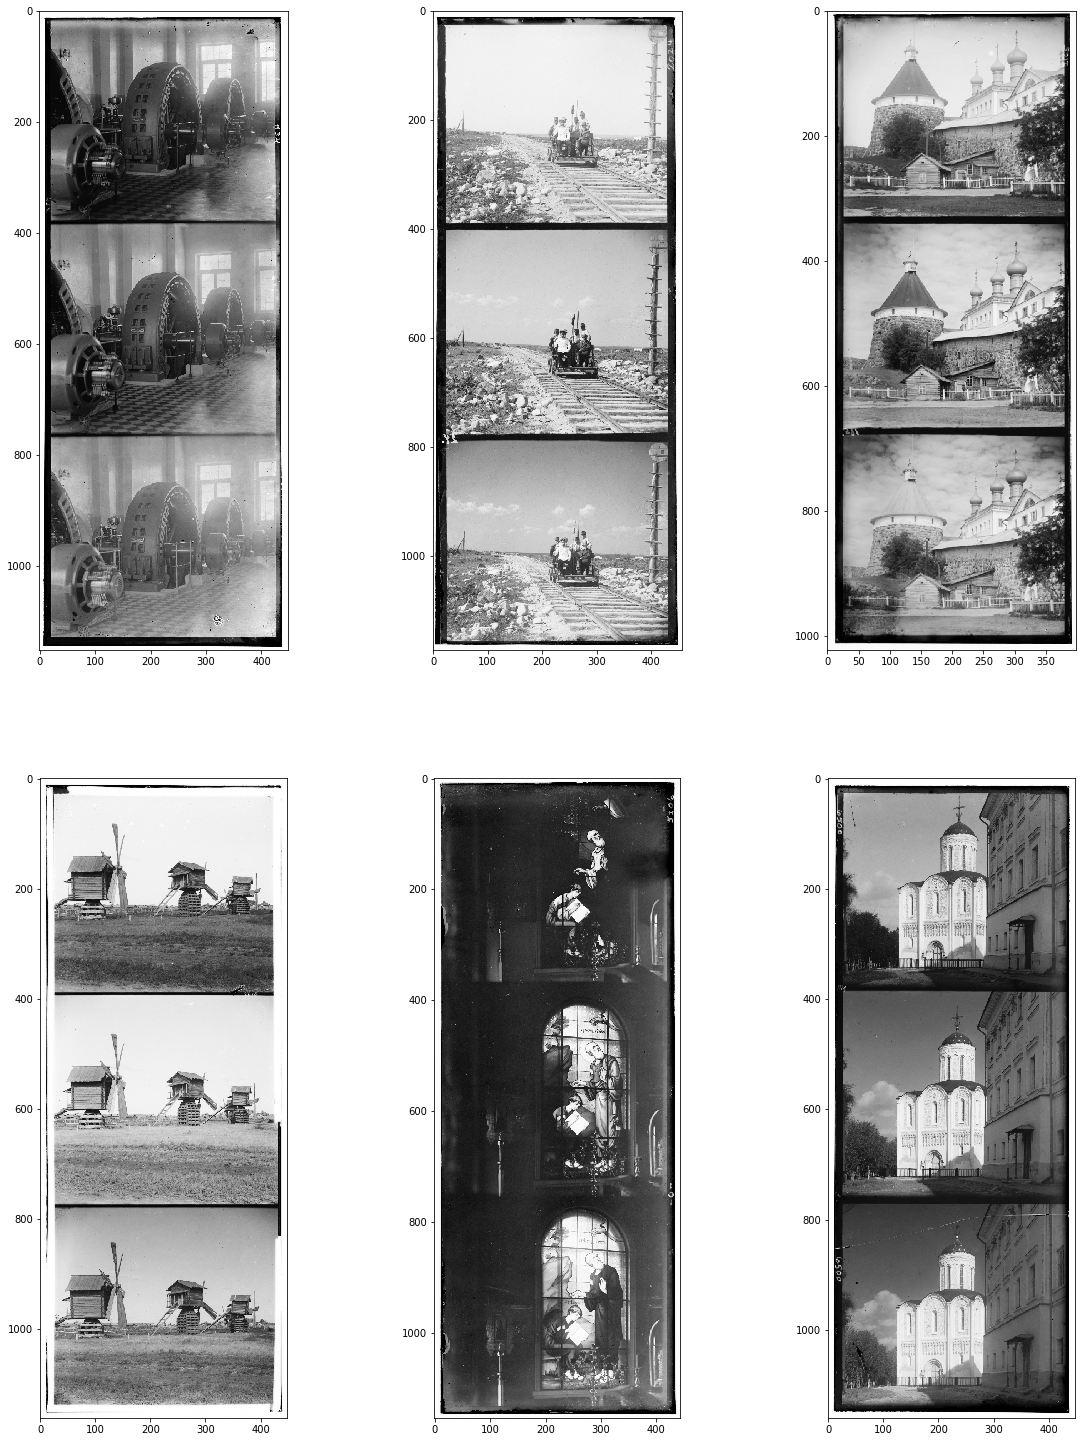

In [3]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    print(enumerate(imgs))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i + 1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(plates, 'gray')

## Border Removal

In order to best align the plates, it is important to remove the borders that frame the images.  This is done by applying a Canny edge detector to each image, finding the rows and columns of the borders, and finally cropping the image to remove the borders.  

#### Canny detector implementation

Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively: 
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, you can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

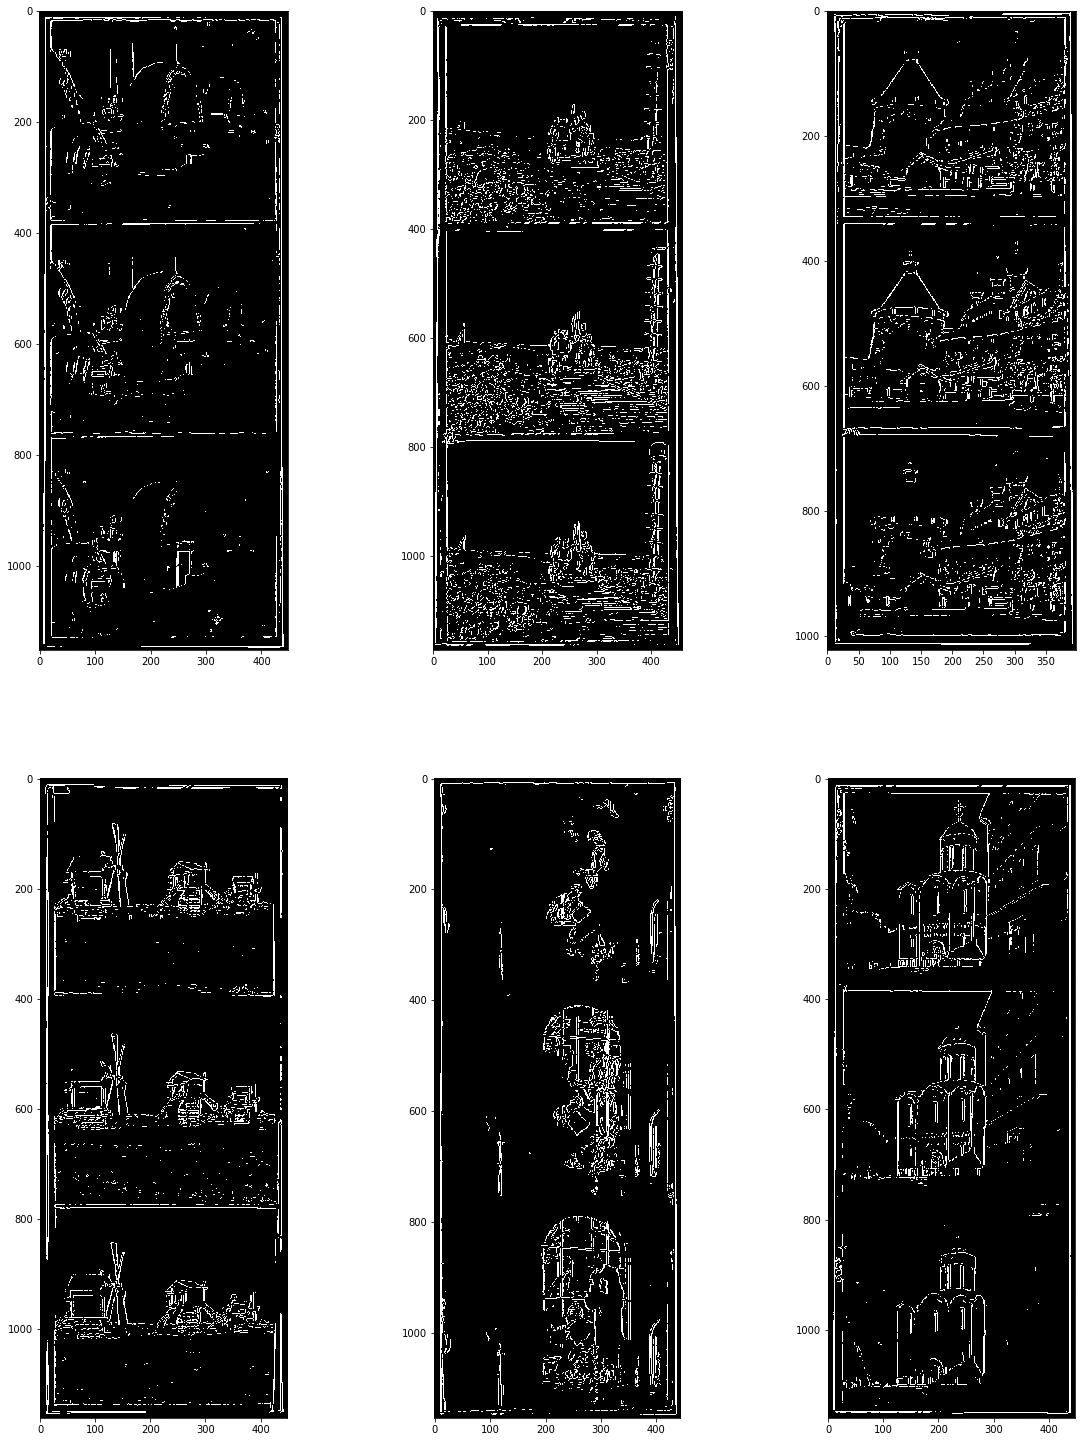

In [9]:
from  skimage.feature import canny
import scipy.ndimage as sim
import math

def Noise_reduction(img):
    img = sim.gaussian_filter(img, sigma=1.4, truncate=1)
    return img

def get_gradient(img) :
    # Find the gradient of image in the x and y directions
    gradient_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    gradient_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
 
    # Combine gradients
    #gradient_magnitude = cv2.addWeighted(np.absolute(gradient_x), 0.5, np.absolute(gradient_y), 0.5, 0)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y,gradient_x)
    
    return gradient_magnitude, gradient_direction

def Suppress_non_maximum(img, gradient_dir):
    # Pixels are set to 0 if they are not the local maximum
    img_maximum_suppressed = img
    
    for x in range(img.shape[0]-1):
        for y in range(img.shape[1]-1):          
            offset = 1 , 1          
            pixelA_mag = img[x + offset[0]][y + offset[1]]
            pixelB_mag = img[x - offset[0]][y + offset[1]]

            if img[x][y] < pixelA_mag or img[x][y] < pixelB_mag:
                img_maximum_suppressed[x][y] = 0
            else:
                img_maximum_suppressed[x][y] = img[x][y]
    
    return img_maximum_suppressed

def Categorize_gradients(img):
    # Replace pixel values with one of the three options:
    weak_border = 1
    strong_border = 2
    threshold_strong = 0.2*numpy.max(img)
    threshold_weak = 0.1*numpy.max(img)
    for x in range(img.shape[0]-1):
        for y in range(img.shape[1]-1): 
            if img[x][y] > threshold_strong:
                img[x][y] = 2
            elif img[x][y] > threshold_weak:
                img[x][y] = 1
            else:
                img[x][y] = 0
    return img

def Edge_enhancement_by_hysteresis(img):
    weak_border = 1
    strong_border = 2
    for x in range(img.shape[0]-1):
        for y in range(img.shape[1]-1): 
            if img[x][y] >= weak_border:
                if img[x+1][y]==strong_border or img[x+1][y+1]==strong_border or img[x+1][y-1]==strong_border or img[x-1][y]==strong_border or img[x-1][y+1]==strong_border or img[x-1][y-1]==strong_border or img[x][y+1]==strong_border or img[x][y-1]==strong_border:
                    img[x][y] = 225
                else:
                    img[x][y] = 0
    return img

def Canny_detector(img): 
    img = Noise_reduction(img)
    img, gradient_dir = get_gradient(img)
    img = Suppress_non_maximum(img, gradient_dir)
    img = Categorize_gradients(img)
    img = Edge_enhancement_by_hysteresis(img)
    return img


canny_imgs = []
for img in plates:
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')

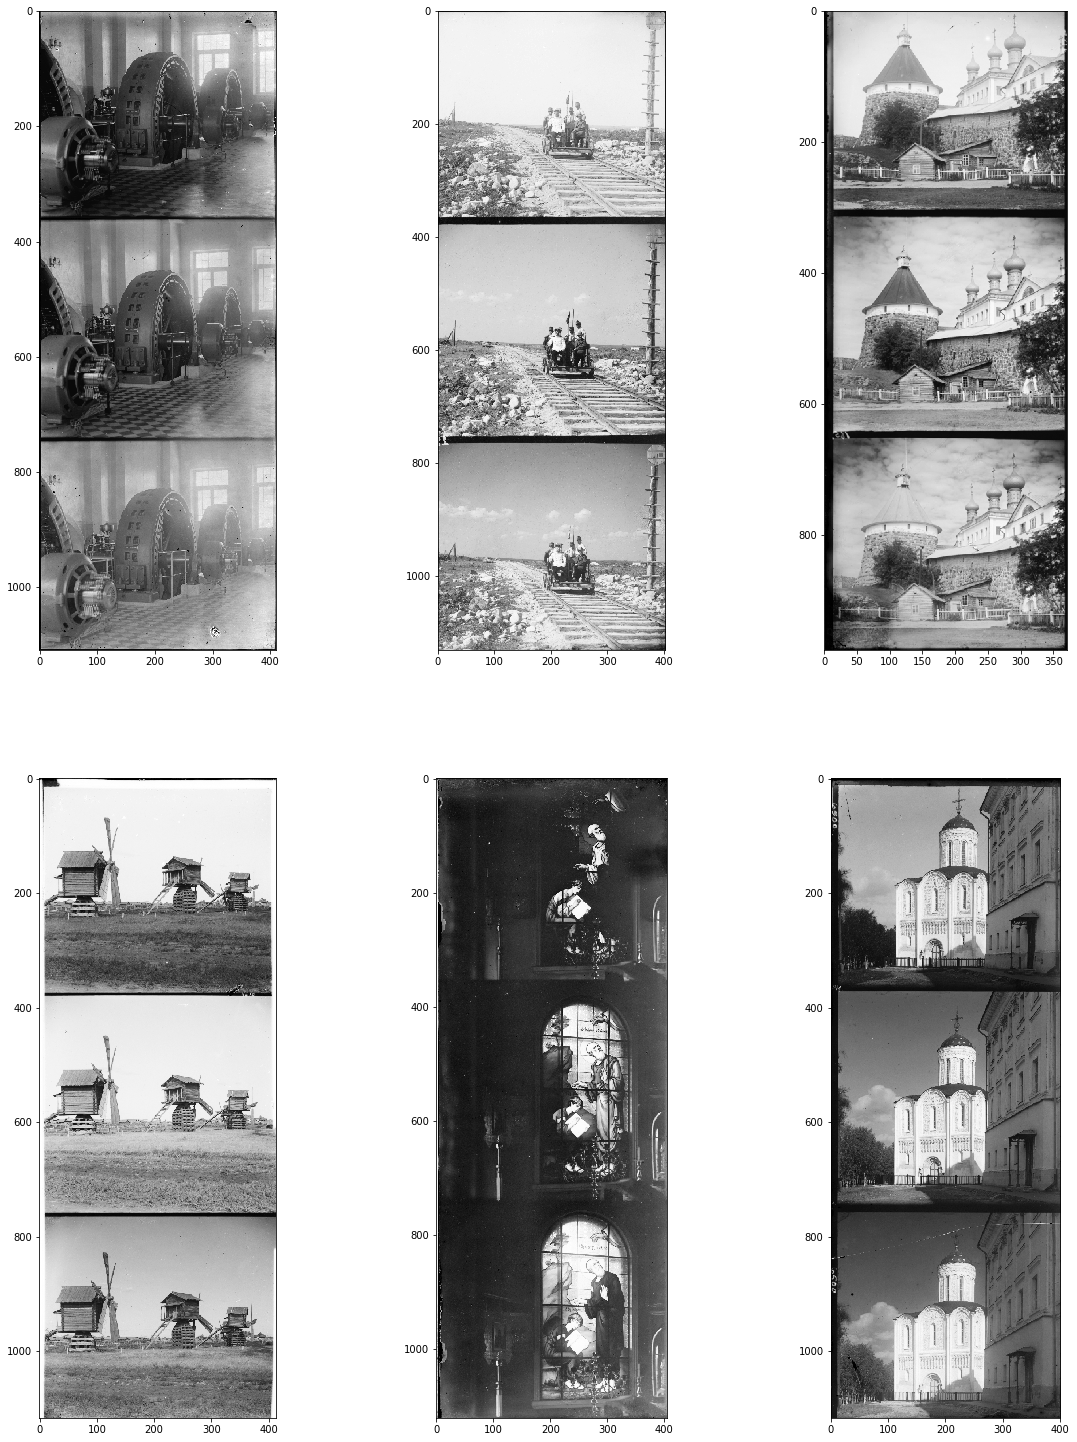

In [10]:
def find_two_maximums(hist):
    # Locate and then remove first maximum.
    max_1 = argmax(hist)
    hist[max_1] = 0
    # Remove bordering points as well so second maximum found will not be right next to the first maximum
    hist[max_1-1] = 0
    hist[max_1+1] = 0
    # Locate second maximum.
    max_2 = argmax(hist)

    return max_1, max_2

def remove_borders(img, canny_img):
    # Assumes that the borders lie in the outermost 10% of image
    # Crop image to contain the outermost 10% of the original image
    dx = int(img.shape[1] * 0.1)  
    left_edge_img = canny_img[0:dx,:]
    right_edge_img = canny_img[-dx:,:]
    top_edge_img = canny_img[:,0:dx]
    bottom_edge_img = canny_img[:,-dx:]
    
    # Create histograms containing the sum of the pixel values along the axis of each border.
    hist_top=np.sum(top_edge_img, axis=0)
    hist_bottom=np.sum(bottom_edge_img, axis=0)
    hist_right=np.sum(right_edge_img, axis=1)
    hist_left=np.sum(left_edge_img, axis=1)

    # Use histograms to find the indices of the two borders in each edge image.
    # Then determine which border is the inmost border and save this index.
    border_locations_top = find_two_maximums(hist_top)  
    crop_top = max(border_locations_top)

    border_locations_bottom = find_two_maximums(hist_bottom)
    crop_bottom = min(border_locations_bottom)
    
    border_locations_left = find_two_maximums(hist_left)
    crop_left = max(border_locations_left)
    
    border_locations_right = find_two_maximums(hist_right)
    crop_right = min(border_locations_right)
        
    # Crop image. Then return cropped image.
    return img[crop_top : -crop_bottom, crop_left : -crop_right]


cropped_imgs = []
#crop borders
for i, img in enumerate(plates):
    cropped_imgs.append(remove_borders(img, canny_imgs[i]))

visualize(cropped_imgs, 'gray')

#### Channels separation

The next step is to separate the image into three channels (B, G, R) and make one colored picture. For now, the plates are simply divided into three equal parts.

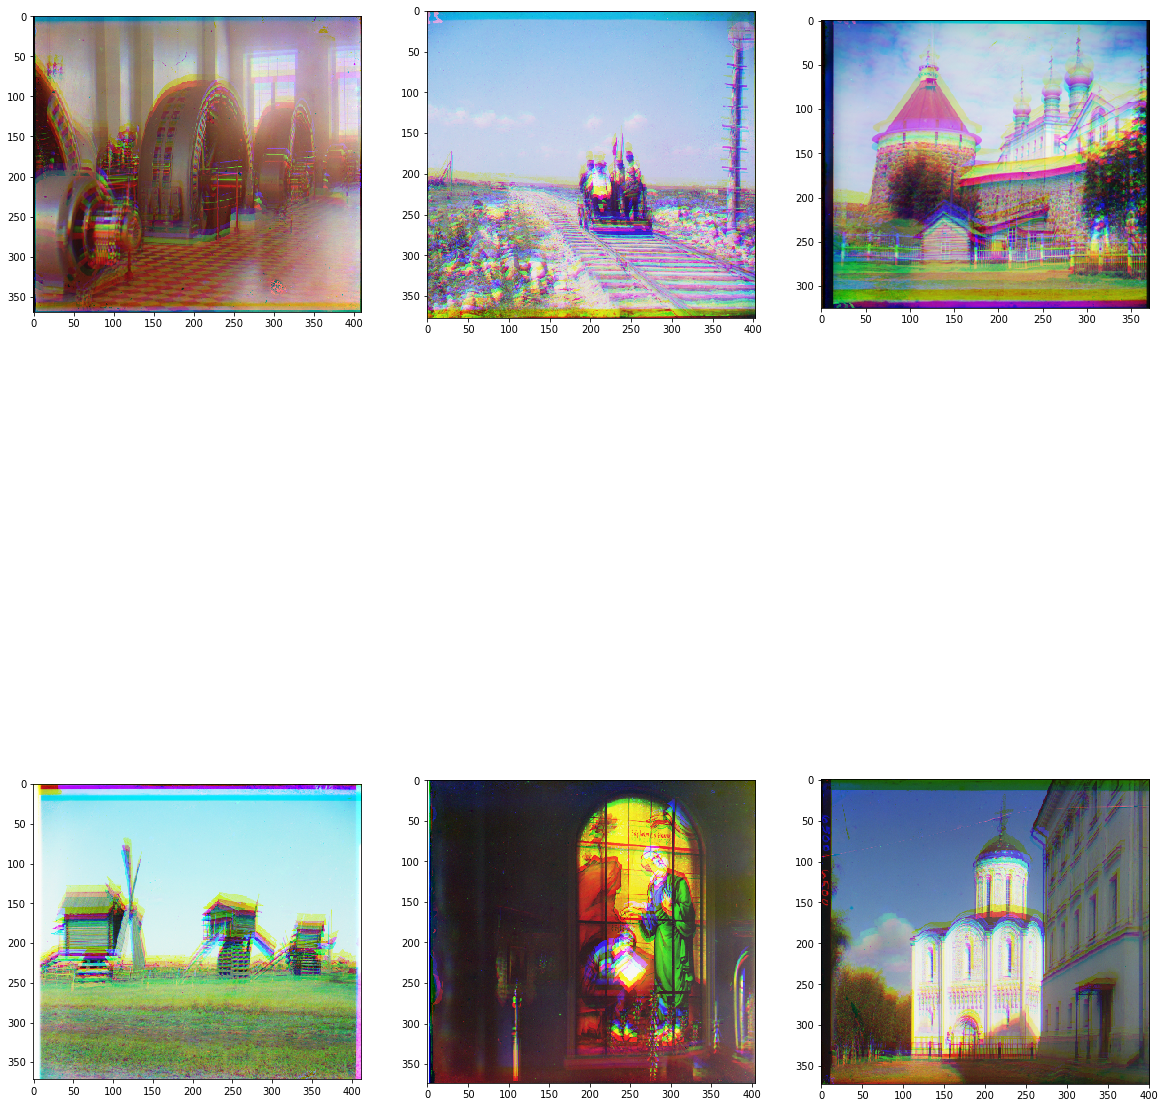

In [11]:
def impose_components(img):
    third = int(img.shape[0] /3)
    
    rgb_array = np.zeros((third,int(img.shape[1]),3), 'uint8')
    
    # Separate image into 3 images
    arr_b = img[0:third,:]
    arr_g = img[third:2*third,:]
    arr_r = img[2*third:3*third,:]
    
    # Store each image in one singe array
    rgb_array[..., 0] = arr_r
    rgb_array[..., 1] = arr_g
    rgb_array[..., 2] = arr_b
    
    image_merged = array(Image.fromarray(rgb_array, 'RGB'))
                    
    return image_merged
   

rgb_imgs = []
for cropped_img in cropped_imgs:
    rgb_img = impose_components(cropped_img)
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

### Search for the best shift for channel alignment

In order to align two images, we will shift one image relative to another within some limits (e.g. from $-15$ to $15$ pixels). For each shift, we can calculate some metrics in the overlap of the images. Depending on the metrics, the best shift is the one the metrics achieves the greatest or the smallest value for. We suggest that you implement two metrics and choose the one that allows to obtain the better alignment quality:

* *Mean squared error (MSE):*<br><br>
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$<br> where *w, h* are width and height of the images, respectively. To find the optimal shift you should find the minimum MSE over all the shift values.
    <br><br>
* *Normalized cross-correlation (CC):*<br><br>
    $$
    I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}.
    $$<br>
    To find the optimal shift you should find the maximum CC over all the shift values.

In [235]:
def mse(X, Y):
    width = X.shape[0]  
    height = X.shape[1]
    mse_total = sum(square(X-Y))/(width*height)
    return mse_total

def cor(X, Y):
    total_cor = sum(X*Y) / (sum(X)*sum(Y))   
    return total_cor

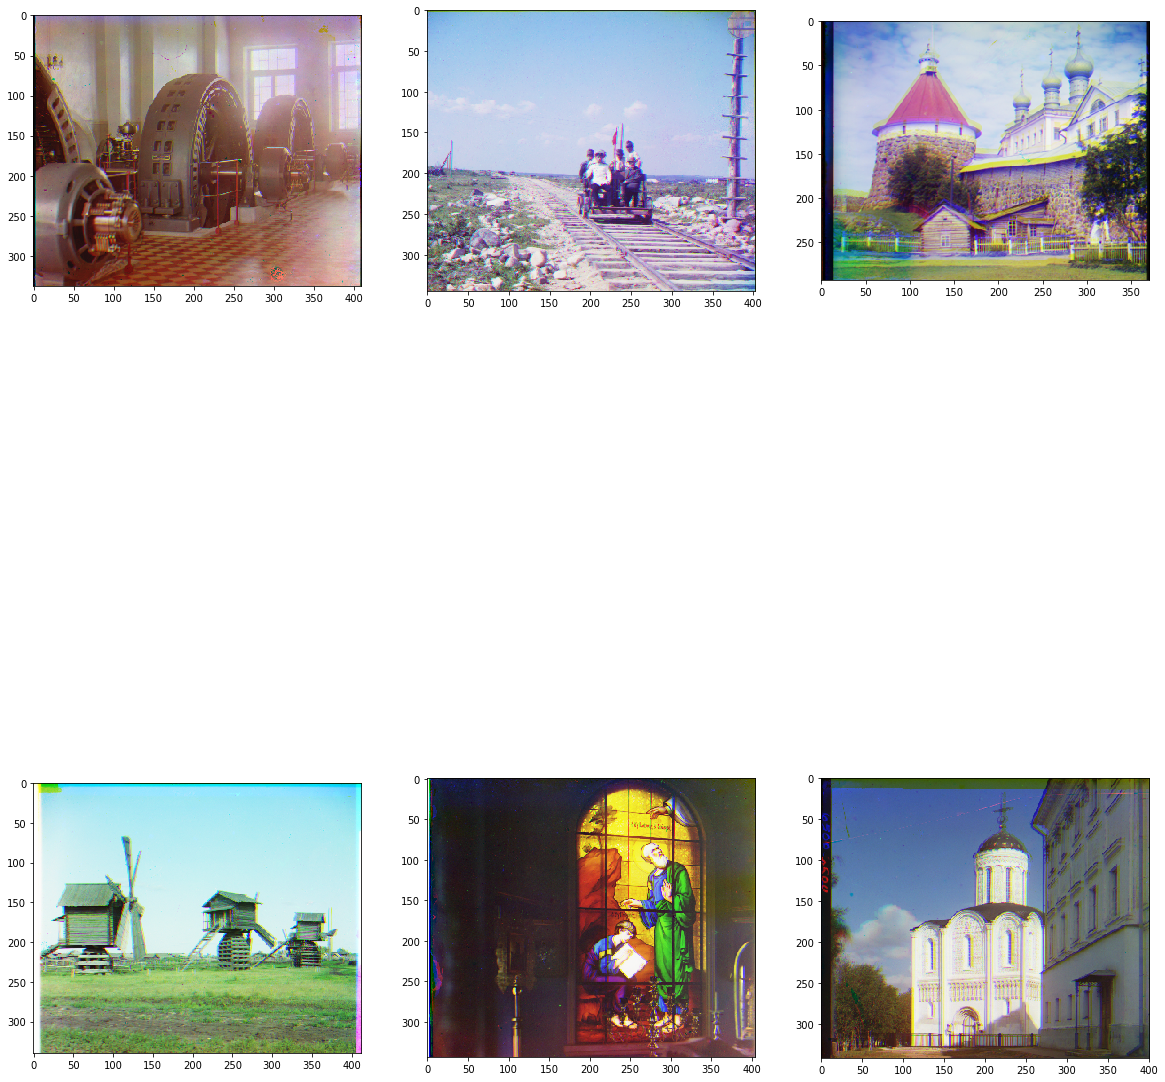

In [236]:
def get_best_shift(image1, image2, comparison_method = 'MSE'):
    # Shift images +- the shift rage in pixels to find the best match
    shift_range = 15  
    # Initializations
    best_shift_mse = 1000000000
    best_shift_cor = 0
    
    # Shift image2 by various amounts of pixels to find the best match
    # To save computation time, only compare a cropped portion of the picture
    for num_pixels_shifted in range(-1*shift_range, shift_range):
        image1_for_comparison = image1[shift_range:-shift_range][shift_range:-shift_range]
        image2_for_comparison = image2[shift_range:-shift_range][shift_range+num_pixels_shifted:-shift_range+num_pixels_shifted]
        # I found that comparing the gradients of images got the best results
        image1_for_comparison, dummy = get_gradient(image1_for_comparison)
        image2_for_comparison, dummy = get_gradient(image2_for_comparison)

        mse_count = mse(image1_for_comparison, image2_for_comparison)
        if mse_count < best_shift_mse:
            best_shift_mse = mse_count
            best_shift_index_mse = num_pixels_shifted

        cor_count = cor(image1_for_comparison, image2_for_comparison)
        if cor_count > best_shift_cor:
            best_shift_cor = cor_count
            best_shift_index_cor = num_pixels_shifted            

    return int((best_shift_index_mse + best_shift_index_cor)/2) # Use both mse and cor results for an average


def get_best_image(rgb_img):
    # Seperate into R, G & B channels
    channel_r = rgb_img[:,:,0]
    channel_g = rgb_img[:,:,1]
    channel_b = rgb_img[:,:,2]
    
    # Compute shift values for best correlation and least mse
    pixels_shifted_from_g_to_r = get_best_shift(channel_r, channel_g)
    pixels_shifted_from_b_to_r = get_best_shift(channel_r, channel_b)
    
    # Find the maximum shift. Image will be cropped by this value for best results.
    max_shift_amount = max(abs(pixels_shifted_from_g_to_r), abs(pixels_shifted_from_b_to_r)) + 1
        
    rgb_shifted_array = np.zeros((int(channel_r.shape[0]-2*max_shift_amount),int(channel_r.shape[1]),3), 'uint8')   
    rgb_shifted_array[..., 0] = channel_r[:][max_shift_amount:-max_shift_amount]
    rgb_shifted_array[..., 1] = channel_g[:][max_shift_amount+pixels_shifted_from_g_to_r:-max_shift_amount+pixels_shifted_from_g_to_r]
    rgb_shifted_array[..., 2] = channel_b[:][max_shift_amount+pixels_shifted_from_b_to_r:-max_shift_amount+pixels_shifted_from_b_to_r]
    image_shifted_merged = array(Image.fromarray(rgb_shifted_array, 'RGB'))
    return image_shifted_merged

final_imgs = []
for img in rgb_imgs:
    final_img = get_best_image(img)
    final_imgs.append(final_img)

visualize(final_imgs)

This project was completed as an assignment in https://www.coursera.org/learn/deep-learning-in-computer-vision/